In [1]:
import numpy as np
import torch as t
from torch.distributions import Normal, Categorical, Bernoulli
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import FloatSlider, IntSlider, interact, interact_manual

$$
\newcommand{\bracket}[3]{\left#1 #3 \right#2}
\newcommand{\b}{\bracket{(}{)}}
\newcommand{\Bernoulli}{{\rm Bernoulli}\b}
\newcommand{\Categorical}{{\rm Categorical}\b}
\newcommand{\x}{\mathbf{x}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\m}{\boldsymbol{\mu}}
\newcommand{\P}{{\rm P}\b}
\newcommand{\dd}[2][]{\frac{\partial #1}{\partial #2}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sh}{\mathbf{\hat{\Sigma}}}
\newcommand{\mh}{\boldsymbol{\hat{\mu}}}
\newcommand{\N}{\mathcal{N}\b}
\newcommand{\det}{\bracket{\lvert}{\rvert}}
\newcommand{\sb}{\bracket{[}{]}}
\newcommand{\E}{\mathbb{E}\sb}
\newcommand{\Var}{{\rm Var}\sb}
\newcommand{\Cov}{{\rm Cov}\sb}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\ph}{\hat{p}}
\newcommand{\at}{\bracket{.}{\rvert}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\Wh}{\mathbf{\hat{W}}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\wh}{\mathbf{\hat{w}}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\La}{\mathbf{\Lambda}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sprior}{\S_\text{prior}}
\newcommand{\Spost}{\S_\text{post}}
\newcommand{\mprior}{\m_\text{prior}}
\newcommand{\mpost}{\m_\text{post}}
\newcommand{\Xt}{\tilde{\X}}
\newcommand{\yt}{\tilde{\y}}
\newcommand{\p}{\mathbf{p}}
\newcommand{\l}{\boldsymbol{\ell}}
\DeclareMathOperator{\softmax}{softmax}
\DeclareMathOperator{\sigmoid}{sigmoid}
$$

<h1> Lecture 4: Classification </h1>

Classification is almost exactly the same as regression, except that:
<ul>
    <li> The outputs, $y$, are discrete class-labels. </li>
    <li> Almost all interesting/useful algorithms require iterative solutions </li>
</ul>
    
The same considerations are relevant, including,
<ul>
    <li> Overfitting </li>
    <li> Regularisation </li>
    <li> Cross-validation </li>
    <li> Bayes (but this is much harder, as there aren't any exact solutions </li>
</ul>

<h2> Prerequisites: Bernoulli distribution for two-class classification</h2>
Samples from the Bernoulli distribution are either $0$ or $1$, with probability given by the parameter,

\begin{align}
  \P{y| p} &= \Categorical{y; p} = y p + (1-y) (1-p)
\end{align}

In [2]:
#A uniform Categorical distribution,
Py = Bernoulli(probs=0.8)
y = Py.sample((10,))
print(y)
print(Py.log_prob(y).exp())

tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 1.])
tensor([0.8000, 0.2000, 0.8000, 0.2000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.8000])


<h3> Logit parameterisation of the Bernoulli distribution and the sigmoid </h3>

Working directly with the probabilities turns out to be problematic:
<ul>
    <li> Probabilities live in a strange range, $0 \leq p \leq 1$. </li>
    <li> There is a strong risk of numerical underflow, which breaks algorithms such as (stochastic) gradient descent. </li>
</ul>

Instead, we can also treat the Categorical parameter as a logits vector, $\ell$, defined such that,

\begin{align}
  p &= \sigmoid(\ell) = \sigma(\ell)\\
  p &= \frac{1}{1+e^{-\ell}}
\end{align}

Now, no matter what $\l$ is, the probabilities must lie in the right range, and they are much less likely to underflow.

PyTorch allows you to directly use the logit parameterisation,

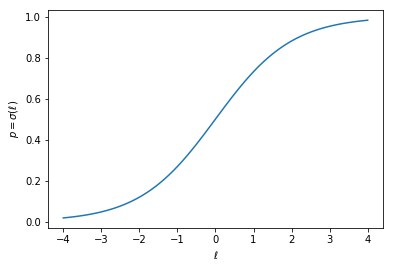

In [3]:
ls = t.linspace(-4, 4, 100)
ps = t.sigmoid(ls)
fig, ax = plt.subplots()
ax.set_xlabel("$\ell$")
ax.set_ylabel("$p = \sigma(\ell)$")
ax.plot(ls, ps);

<h2> Prerequisites: Categorical distribution for multi-class classification </h2>

Samples from the Categorical distribution are integers $0 \leq y < K$, with probability given explicity by a length $K$ vector of, $\p$,

\begin{align}
  \P{y| \p} &= \Categorical{y; \p} = p_y
\end{align}

In [4]:
#A uniform Categorical distribution,
Py = Categorical(probs=t.ones(10)/10)
y = Py.sample((20,))
y

tensor([8, 3, 4, 1, 1, 3, 5, 8, 1, 2, 0, 7, 3, 2, 7, 4, 7, 7, 4, 5])

In [5]:
Py.log_prob(y).exp()

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000])

In [6]:
#A non-uniform Categorical distribution,
p = t.tensor([0.5, 0.1, 0.1, 0.1, 0.1, 0.1])
Py = Categorical(probs=p)
y = Py.sample((20,))
y

tensor([2, 2, 0, 0, 1, 0, 2, 0, 4, 0, 0, 1, 4, 0, 0, 0, 0, 1, 4, 0])

In [7]:
Py.log_prob(y).exp()

tensor([0.1000, 0.1000, 0.5000, 0.5000, 0.1000, 0.5000, 0.1000, 0.5000, 0.1000,
        0.5000, 0.5000, 0.1000, 0.1000, 0.5000, 0.5000, 0.5000, 0.5000, 0.1000,
        0.1000, 0.5000])

<h3> Logit parameterisation of the Categorical distribution and the softmax </h3>

Working directly with the probabilities turns out to be problematic:
<ul>
    <li> Probabilities live in a strange range, $0 \leq p_i \leq 1$. </li>
    <li> Probabilities must sum to $1$. </li>
    <li> There is a strong risk of numerical underflow, which breaks algorithms such as (stochastic) gradient descent. </li>
</ul>

Instead, we can also treat the Categorical parameter as a logits vector, $\l$, defined such that,

\begin{align}
  \p &= \softmax(\l)\\
  p_i &= \frac{e^{\ell_i}}{\sum_j e^{\ell_j}}
\end{align}

Now, no matter what $\l$ is, the probabilities must lie in the right range, they must normalize, and they are much less likely to underflow.

PyTorch allows you to directly use the logit parameterisation,

In [8]:
# Uniform Categorical
Py = Categorical(logits = t.zeros(10))
y = Py.sample((20,))
y

tensor([2, 2, 3, 3, 8, 4, 8, 8, 1, 5, 3, 9, 6, 0, 4, 2, 7, 5, 7, 6])

In [9]:
Py.log_prob(y).exp()

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000])

In [10]:
# Non-uniform Categorical
l = t.tensor([1., 0., -1., -2., -10.])
Py = Categorical(logits = l)
y = Py.sample((20,))
y

tensor([0, 0, 0, 1, 1, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0])

In [11]:
Py.log_prob(y).exp()

tensor([0.6439, 0.6439, 0.6439, 0.2369, 0.2369, 0.6439, 0.6439, 0.6439, 0.0321,
        0.6439, 0.2369, 0.6439, 0.6439, 0.6439, 0.6439, 0.0871, 0.6439, 0.6439,
        0.6439, 0.6439])

<h2> Formalising maximum-likelihood supervised learning </h2>

The most abstract form of a supervised learning problem is given by,

In [24]:
class Supervised:
    def __init__(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        
    def L(self, theta):
        # use predict to get the distribution P(y| x, W)
        Py = self.predict(self.X_train, theta)
        # compute the log-probability of the data y under that distribution
        return Py.log_prob(self.Y_train).sum()

This class records the training inputs, X, and outputs, Y.

The log-likelihood objective, `L`, is a function of the parameters, `theta`.

`predict`, takes the training inputs and parameters, and gives a _distribution_ over the training outputs.

To compute the objective, we compute the log-probability of the observed training outputs, under the predicted distribution.

To get linear regression, we simply need to provide the right `predict` function,

In [23]:
class LinearRegression(Supervised):
    def predict(self, X, theta):
        Xb = t.cat([X, t.ones(X.shape[0], 1)], 1)
        (W, sigma) = theta
        return Normal(Xb@W.T, sigma**2)

And to get logistic regression, we provide a different `predict` function,

In [22]:
class MultiLogisticRegression(Supervised):
    def predict(self, X, theta):
        Xb = t.cat([X, t.ones(X.shape[0], 1)], 1)
        W = theta
        return Categorical(logits=Xb@W.T)
    
class TwoLogisticRegression(Supervised):
    def predict(self, X, theta):
        W = theta
        return Bernoulli(logits=X@W.T)

As an example, consider the "Iris" dataset, which is about classifying flowers based on features such as Petal length.

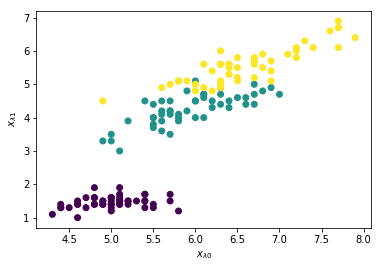

In [15]:
from sklearn import datasets
iris = datasets.load_iris()
_X = t.tensor(iris['data'][:, [0, 2]]).float()
_Y = t.tensor(iris['target'])

fig, ax = plt.subplots()
ax.set_xlabel("$x_{\lambda 0}$")
ax.set_ylabel("$x_{\lambda 1}$")
ax.scatter(_X[:, 0], _X[:, 1], c=_Y);

Split the data into train and test (we shuffle the data first, because the classes are ordered)

In [21]:
t.manual_seed(0)
perm = t.randperm(_X.shape[0])
X = _X[perm, :]
Y = _Y[perm]

X_train = X[:100, :]
Y_train = Y[:100]
X_test  = X[100:, :]
Y_test  = Y[100:]

lr = MultiLogisticRegression(X_train, Y_train)

There are some more quicker iterative algorithms.  But they don't add much understanding.  So instead, we use PyTorch-magic to do gradient-descent.

In [17]:
W = t.zeros((3,3), requires_grad=True)

for i in range(50000):
    L = lr.L(W)
    if 0==i % 1000:
        print(L.item())
    dW = t.autograd.grad(outputs=L, inputs=(W,))[0]
    W.data += 0.001*dW

-109.8612289428711
-21.01755714416504
-17.335208892822266
-15.750432968139648
-14.77529525756836
-14.073020935058594
-13.524309158325195
-13.075104713439941
-12.696579933166504
-12.371374130249023
-12.088096618652344
-11.838754653930664
-11.61744499206543
-11.419652938842773
-11.24185848236084
-11.081212043762207
-10.935394287109375
-10.80250358581543
-10.68095588684082
-10.56940746307373
-10.466708183288574
-10.371901512145996
-10.284147262573242
-10.202718734741211
-10.126993179321289
-10.056436538696289
-9.990544319152832
-9.9288911819458
-9.87112045288086
-9.816884994506836
-9.765900611877441
-9.717900276184082
-9.672636032104492
-9.629910469055176
-9.589515686035156
-9.55129337310791
-9.515084266662598
-9.480740547180176
-9.448126792907715
-9.417137145996094
-9.387653350830078
-9.359598159790039
-9.332863807678223
-9.307355880737305
-9.283014297485352
-9.259759902954102
-9.237544059753418
-9.216300010681152
-9.195947647094727
-9.176482200622559


Now, we can compute the classification-error,

In [18]:
def class_error(X, Y):
    Py = lr.predict(X, W)
    pred = Py.probs.argmax(1)
    N_correct = (pred == Y).sum()
    print(f"{N_correct}/{X.shape[0]} = {100.*N_correct/X.shape[0]}%")
    
print("Training correct")
class_error(X_train, Y_train)

print("Test correct")
class_error(X_test, Y_test)

Training correct
98/100 = 98.0%
Test correct
47/50 = 94.0%


Note that the classifier performs really well on training data, but less well on test data.

Indicates evidence of overfitting.

<h2> Overfitting in classification</h2>

In [20]:
def cheb(xs, c):
    # c is int
    coefs = c*[0] + [1]
    return np.polynomial.chebyshev.chebval(xs, coefs)
def chebX(X, order):
    assert (-1 <= X).all() and (X <= 1).all()
    
    xs = []
    for c in range(order):
        xs.append(cheb(X, c))
    return t.cat(xs, 1)
t.manual_seed(0)
N = 100
X = 2*t.rand(N, 1)-1
W_true = t.tensor([[4.]])
Y = Bernoulli(logits=X@W_true.T).sample()

def plot(order):
    Xe= chebX(X, order)

    lr = TwoLogisticRegression(Xe, Y)

    W = t.zeros((1,order), requires_grad=True)


    for i in range(15000):
        L = lr.L(W)
        if 0==i % 2000:
            print(L.item())
        dW = t.autograd.grad(outputs=L, inputs=(W,))[0]
        W.data += 0.001*dW
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$x$")
    ax.set_ylabel("probability / $y$")
    ax.scatter(X, Y)
    xs = t.linspace(-1, 1, 100)[:, None]
    ps_fitted = lr.predict(chebX(xs, order), W).probs.detach()
    ps_true = lr.predict(xs, W_true).probs.detach()
    ax.plot(xs, ps_fitted, label="fitted probability")
    ax.plot(xs, ps_true, label="true probability")
    ax.legend()
    
interact_manual(plot, order=IntSlider(min=2, max=30));

interactive(children=(IntSlider(value=2, description='order', max=30, min=2), Button(description='Run Interact…

You can use the same techniques to control overfitting:
<ul>
    <li> Regularisation </li>
    <li> Cross-validation (either on the number of classification errors for test points, or on the test-log-likelihood </li>
    <li> Bayesian inference (though its much harder here because the posterior over the weights doesn't have an analytiv form)
<ul>